In [1]:
# !sudo apt-get install python3.7
# !sudo apt-get update -y
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --config python3

In [2]:
"""
maximum availible volume to pool into
"""
max_volume=500

"""
maximum availible volume to be taken out of well
"""
max_oligo_volume=80

"""
maximum availible volume to be taken out of well
"""
min_oligo_volume=4

# """
# target moles of oligo pmol
# """
# target_quantity=90

In [3]:
!pip install numpy
!pip install pyopenms
!pip install biopython
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [5]:
import re

# "OVFF368"
EXPERIMENT_NAME = input()
# reading file
file1 = open(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}.txt', 'r')
oligo_list = [line for line in file1.readlines() if re.search("^[a-zA-Z][1-9]", line)]
import csv

header = ['where\tcode\tseq\tDMT\tcomment\tlength\t']
data = [row.strip() for row in oligo_list]


with open(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_oligos.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

    writer = csv.writer(f, quotechar='\"', delimiter='\n', quoting=csv.QUOTE_NONE, escapechar='\\')
    # write the data
    writer.writerow(data)

KJE0016


FileNotFoundError: [Errno 2] No such file or directory: './content/KJE0016/KJE0016.txt'

In [ ]:
import pandas as pd

df = pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_oligos.csv', delimiter='\t')
# drop NaN seq
df = df[df['seq'].notna()]
oligo_list = df['seq'].to_list()

In [ ]:
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight

# Bio.SeqUtils.molecular_weight(seq, seq_type='DNA', double_stranded=False, circular=False, monoisotopic=False)

from pyopenms import *

mass_list=[]
# https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
for oligo_seq in oligo_list: 
    try:
        my_dna = Seq(oligo_seq)
    except:
        print(oligo_seq)
    try:
        print(f"{oligo_seq.strip()}\t" + "%0.2f" % (molecular_weight(my_dna)-79.97))
        mass_list+=["%0.2f" % (molecular_weight(my_dna)-79.97)]
    except ValueError:
        print(f"{oligo_seq.strip()}\t" + "'N' is not a valid unambiguous letter for DNA")
        mass_list+=["NaN"]
    
df['monoisotopic_mass']=mass_list
export_dataframe=df[['where', 'code', 'length', 'seq', 'monoisotopic_mass']]
export_dataframe.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_calculated.csv', sep = '\t', index=False)


In [12]:
# reading file with seqs 
df_calculated =  pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_calculated.csv', delimiter='\t', decimal=".")

# read concentrations file
try: 
    df = pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_concentrations.csv', delimiter=';', decimal=".")
except FileNotFoundError:
    df = pd.read_excel(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_concentrations.xlsx')

"""
strip the text everywhere on data frame
"""
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())
"""
and again
"""
cols = df_calculated.select_dtypes(object).columns
df_calculated[cols] = df_calculated[cols].apply(lambda x: x.str.strip())

"""
now merge cleaned dataframes
"""
merge = pd.merge(df, df_calculated, on='where', how='inner', suffixes=('', '_drop'))
#Drop the duplicate columns
merge.drop([col for col in merge.columns if 'drop' in col], axis=1, inplace=True)

# reassign
df = merge

In [13]:
df

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),Baseline Absorbance,code,length,seq,monoisotopic_mass
0,P19,10/24/2023 5:41:09 AM,P19,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,phiX174-V2_F3-33,#= 45,CAA TGA CCA AAT CAA AGA AAT GAC TCG CAA GGT TA...,13935.01
1,P19,10/24/2023 5:41:09 AM,P19,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,Unnamedsequence_F0-0,#= 19,TGT TGA GTG GCG GCG AGT T,5930.83
2,A20,10/24/2023 5:42:03 AM,A20,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,phiX174-V2_F3-34,#= 55,TAC CGC TGA TTC TGC GTT TGC TGA TGA ACT AAG TC...,16795.79
3,A20,10/24/2023 5:42:03 AM,A20,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,Unnamedsequence_F0-1,#= 42,AAC TCG CCG CCA CTC AAC ACC CCG GAG AGT GAA GT...,12808.24
4,B20,10/24/2023 5:42:45 AM,B20,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,phiX174-V2_F3-35,#= 54,AAA CGC AGA ATC AGC GGT ATG GCT CTT CTC ATA TT...,16653.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,D22,10/24/2023 6:05:27 AM,D22,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,Unnamedsequence_F0-36,#= 51,TCC CAC GGT TCC ACA TAG TCC AGA CCC AGA TGC GC...,15498.97
74,E22,10/24/2023 6:06:16 AM,E22,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,phiX174-V2_F4-24,#= 42,CGC TAC CTG TAG GAA GTG TCC GCA TAA AGT GCA CC...,12948.33
75,E22,10/24/2023 6:06:16 AM,E22,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,Unnamedsequence_F0-37,#= 39,GAC TAT GTG GAA CCG TGG GAA CGC AAC GCC GCG AA...,12075.78
76,F22,10/24/2023 6:06:58 AM,F22,1552.570476,1.818214,1.989714,47.047619,25.797667,33,340,0.425952,phiX174-V2_F4-25,#= 48,GAC ACT TCC TAC AGG TAG CGT TGA CCC TAA TTT TG...,14765.47


In [14]:
import sys
from Bio.Seq import Seq

# calculation of oligo extinction coefficients (mM^–1*cm^–1);
def e260_func(sequence):
    Coefficients = {
        "a": 15.4,
        "c": 7.4,
        "g": 11.5,
        "t": 8.7,
        "aa": 13.7,
        "ac": 10.6,
        "ag": 12.5,
        "at": 11.4,
        "ca": 10.6,
        "cc": 7.3,
        "cg": 9,
        "ct": 7.6,
        "ga": 12.6,
        "gc": 8.8,
        "gg": 10.8,
        "gt": 10,
        "ta": 11.7,
        "tc": 8.1,
        "tg": 9.5,
        "tt": 8.4,
    }
    
    Coefficients =  {key.upper(): val for key, val in Coefficients.items()}
    e260 = 0
    sequence = Seq(sequence.replace(" ", ""))
    
    for i in range(0, len(sequence) - 1):
        e260 = e260 + 2 * Coefficients[sequence[i] + sequence[i + 1]]
    for i in range(0, len(sequence) - 2):
        e260 = e260 - Coefficients[sequence[i + 1]]
    return e260

# CHANGE THIS LATER
Yield = 100

df["e260_mM^-1cm^-1"] = df["seq"].map(e260_func)
df["corrected_molar_concentration_pmol/mkl"] = (1000*2*df["A260"] / (df["e260_mM^-1cm^-1"] * (1 + (100/ Yield)))) ## (mmol/L == nmol/mkl)
df["corrected_weght_concentration"]=df["corrected_molar_concentration_pmol/mkl"]*df["monoisotopic_mass"]/1000 ## ng/mkl
df["corrected_Nucleic_Acid_Factor"]=(2/(df["e260_mM^-1cm^-1"] * (1 + (100/ Yield))))*df["monoisotopic_mass"]

df = df.round(2)

# write final merged result
df.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_merged_input.csv', encoding='UTF8')

In [15]:

def detect_pool_name(a, b):

    common_prefix = ''

    for x,y in zip(a, b):
        if x == y:
            common_prefix += x
        else:
            break
    common_prefix = common_prefix.strip("1234567890")
    
    regex_special_chars = "[]\.^$*+?{}|()"
    common_prefix_for_regex = common_prefix
    
    for charachter in regex_special_chars:
        # replace() "returns" an altered string
        replace_with = f"\\{charachter}"
        common_prefix_for_regex = common_prefix_for_regex.replace(charachter, replace_with)

    if re.findall(f'{common_prefix_for_regex}\d+$', b):
        return common_prefix
    
    
def detect_pool_names(df):
    possible_pool_names = []
    for index in range(len(df["code"])-1):
        a = df["code"][index]
        b = df["code"][index+1]
        
        pool_name = detect_pool_name(a, b)
        if (pool_name not in possible_pool_names) & (pool_name!=None):        
            possible_pool_names+=[pool_name]
    return possible_pool_names
    
possible_pool_names = detect_pool_names(df)


In [16]:
possible_pool_names



['']

In [17]:
for i in df.columns:
    try:
        df[i] = df[i].str.replace(',', '.').astype(float)
    except:
        pass
    
df['monoisotopic_mass'] = df['monoisotopic_mass'].astype(float)
df["pM/mkl"] = 1000*df['Nucleic Acid(ng/uL)']/df['monoisotopic_mass']
# df=df.dropna()

"""
ATTENTION!!! HERE YOU CAN CHANGE POOL NAME!!!
"""

pool_1 = "Unnamedsequence_F0-"

POOL_NAME=pool_1

df = df[df["code"].str.contains(f'{POOL_NAME}\d+')]
df = df.loc[0:53]

df

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),Baseline Absorbance,code,length,seq,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl
1,P19,10/24/2023 5:41:09 AM,P19,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-0,#= 19,TGT TGA GTG GCG GCG AGT T,5930.83,181.5,259.22,1537.36,32.68,261.779549
3,A20,10/24/2023 5:42:03 AM,A20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-1,#= 42,AAC TCG CCG CCA CTC AAC ACC CCG GAG AGT GAA GT...,12808.24,395.8,118.87,1522.48,32.36,121.216498
5,B20,10/24/2023 5:42:45 AM,B20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-2,#= 51,CAC GAA TAC TGC GAG ACC TTG GTC GCG ATA AAG CT...,15620.03,477.5,98.53,1539.03,32.71,99.396096
7,C20,10/24/2023 5:43:22 AM,C20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-3,#= 51,CAA GGT CTC GCA GTA TTC GTG TCA ACG CAA AAC CA...,15574.06,496.3,94.80,1476.37,31.38,99.689484
9,D20,10/24/2023 5:43:58 AM,D20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-4,#= 52,TAA TTT CGA AGG CAT CGG TGA ATT TTT TGT TGT AG...,16152.36,496.7,94.72,1529.96,32.52,96.120319
11,E20,10/24/2023 5:44:32 AM,E20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-5,#= 49,ATT CAC CGA TGC CTT CGA AAT TAT GGC CGA AAA CT...,15079.76,493.1,95.41,1438.79,30.58,102.957209
13,F20,10/24/2023 5:45:26 AM,F20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-6,#= 57,CGC GCA GAA ATT CAA GAC AAA AAA TCT CGT TTT CT...,17468.28,554.0,84.92,1483.47,31.53,88.879386
15,G20,10/24/2023 5:46:01 AM,G20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-7,#= 55,TTT TGT CTT GAA TTT CTG CGC GCA GCG TCC CTT CT...,16760.72,487.4,96.53,1617.87,34.39,92.631462
17,H20,10/24/2023 5:46:31 AM,H20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-8,#= 54,CAT GGC AGG CCC TGG ATA TCT TTC ATG CGC GTA AC...,16668.68,510.0,92.25,1537.69,32.68,93.142948
19,I20,10/24/2023 5:47:03 AM,I20,1552.57,1.82,1.99,47.05,25.8,33,340,0.43,Unnamedsequence_F0-9,#= 50,ATA TCC AGG GCC TGC CAT GCA TGG GTG ACC AGG TC...,15440.92,486.3,96.75,1493.85,31.75,100.549061


Text(0, 0.5, 'occurencies')

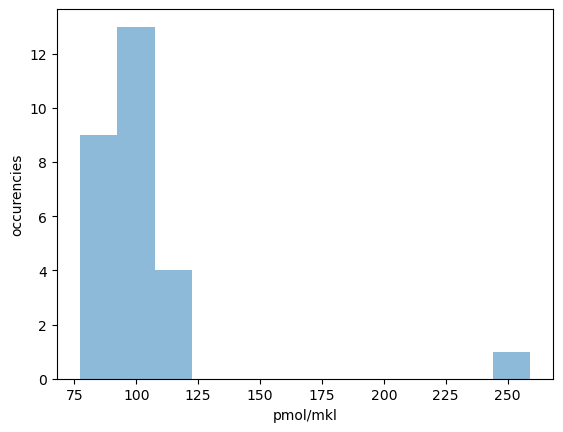

In [18]:
"""
смотрим распределение по корзинам
"""
ax = df['corrected_molar_concentration_pmol/mkl'].plot.hist(bins=12, alpha=0.5)
initial_oligos_concentrations = df['corrected_molar_concentration_pmol/mkl']
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [19]:
'''
определяем выбросы
'''
import pandas
import numpy as np
from scipy import stats

# %reload_ext google.colab.data_table

df['score'] = np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl']))<1.8
# df[(np.abs(stats.zscore(df)) < 1.5).all(axis=1)]
filtered, filtered_off = (df[(np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl'])) < 1.8)], df[(np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl'])) >= 1.8)])
filtered_off

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),...,code,length,seq,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl,score
1,P19,10/24/2023 5:41:09 AM,P19,1552.57,1.82,1.99,47.05,25.8,33,340,...,Unnamedsequence_F0-0,#= 19,TGT TGA GTG GCG GCG AGT T,5930.83,181.5,259.22,1537.36,32.68,261.779549,False


Text(0, 0.5, 'occurencies')

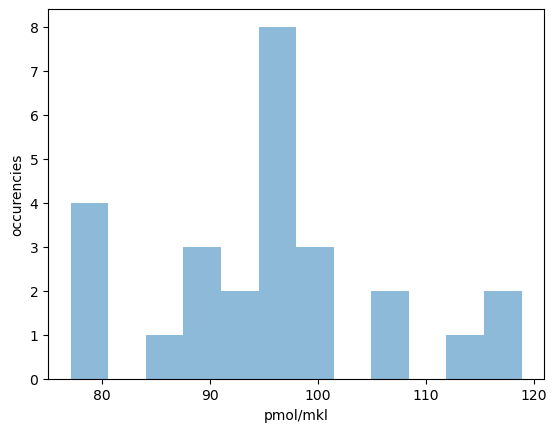

In [20]:
"""
смотрим распределение по корзинам
"""
ax = filtered['corrected_molar_concentration_pmol/mkl'].plot.hist(bins=12, alpha=0.5)
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [21]:
"""
split into N bins by quantiles
"""
N = 8

labels=list(np.arange(1, N))
labels = [str(elem) for elem in labels]
q = list(np.linspace(0, 1, N))

filtered["quantile"] = pd.qcut(df['corrected_molar_concentration_pmol/mkl'], q=q, labels=labels)

'''
выравниваем группы концентраций в пределах отличия в 1.5 раз
'''
highest_quantile_median_conc = filtered[filtered['quantile'] == labels[-1]]['corrected_molar_concentration_pmol/mkl'].median()
for i in labels:
    
    i_quantile_median_conc = filtered[filtered['quantile'] == i]['corrected_molar_concentration_pmol/mkl'].median()
    mkl = round(5*highest_quantile_median_conc/i_quantile_median_conc)
    filtered.loc[filtered['quantile'] == i, ['mkl']] = mkl


"""
пересчитываем моли
"""
filtered['pmol'] = filtered['mkl']*filtered['corrected_molar_concentration_pmol/mkl']
median_conc = round(filtered['corrected_molar_concentration_pmol/mkl'].median())
median_moles_in_pool = round(filtered['pmol'].median())
# print(filtered.sort_values('pM/mkl'))
print(f"equalized result: median_moles_in_pool = {median_moles_in_pool}")
filtered

equalized result: median_moles_in_pool = 580


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),...,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl,score,quantile,mkl,pmol
3,A20,10/24/2023 5:42:03 AM,A20,1552.57,1.82,1.99,47.05,25.8,33,340,...,12808.24,395.8,118.87,1522.48,32.36,121.216498,True,7,5.0,594.35
5,B20,10/24/2023 5:42:45 AM,B20,1552.57,1.82,1.99,47.05,25.8,33,340,...,15620.03,477.5,98.53,1539.03,32.71,99.396096,True,5,6.0,591.18
7,C20,10/24/2023 5:43:22 AM,C20,1552.57,1.82,1.99,47.05,25.8,33,340,...,15574.06,496.3,94.80,1476.37,31.38,99.689484,True,3,6.0,568.80
9,D20,10/24/2023 5:43:58 AM,D20,1552.57,1.82,1.99,47.05,25.8,33,340,...,16152.36,496.7,94.72,1529.96,32.52,96.120319,True,3,6.0,568.32
11,E20,10/24/2023 5:44:32 AM,E20,1552.57,1.82,1.99,47.05,25.8,33,340,...,15079.76,493.1,95.41,1438.79,30.58,102.957209,True,4,6.0,572.46
13,F20,10/24/2023 5:45:26 AM,F20,1552.57,1.82,1.99,47.05,25.8,33,340,...,17468.28,554.0,84.92,1483.47,31.53,88.879386,True,2,7.0,594.44
15,G20,10/24/2023 5:46:01 AM,G20,1552.57,1.82,1.99,47.05,25.8,33,340,...,16760.72,487.4,96.53,1617.87,34.39,92.631462,True,4,6.0,579.18
17,H20,10/24/2023 5:46:31 AM,H20,1552.57,1.82,1.99,47.05,25.8,33,340,...,16668.68,510.0,92.25,1537.69,32.68,93.142948,True,3,6.0,553.50
19,I20,10/24/2023 5:47:03 AM,I20,1552.57,1.82,1.99,47.05,25.8,33,340,...,15440.92,486.3,96.75,1493.85,31.75,100.549061,True,5,6.0,580.50
21,J20,10/24/2023 5:47:41 AM,J20,1552.57,1.82,1.99,47.05,25.8,33,340,...,15574.02,481.8,97.65,1520.80,32.32,99.689740,True,5,6.0,585.90


In [22]:
filtered_off['mkl'] = median_moles_in_pool/filtered_off['corrected_molar_concentration_pmol/mkl']
filtered_off.loc[filtered_off['mkl'] >= max_oligo_volume, ['mkl']] = max_oligo_volume
filtered_off.loc[filtered_off['mkl'] <= min_oligo_volume, ['mkl']] = min_oligo_volume
filtered_off['mkl'] = round(filtered_off['mkl'])
filtered_off

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,where,Date,Sample Name,Nucleic Acid(ng/uL),A260/A280,A260/A230,A260,A280,Nucleic Acid Factor,Baseline Correction (nm),...,length,seq,monoisotopic_mass,e260_mM^-1cm^-1,corrected_molar_concentration_pmol/mkl,corrected_weght_concentration,corrected_Nucleic_Acid_Factor,pM/mkl,score,mkl
1,P19,10/24/2023 5:41:09 AM,P19,1552.57,1.82,1.99,47.05,25.8,33,340,...,#= 19,TGT TGA GTG GCG GCG AGT T,5930.83,181.5,259.22,1537.36,32.68,261.779549,False,4.0


In [23]:
"""
FINAL CONCATENATION AND VOLUME ASSERTION TEST
"""
result = pd.concat([filtered_off, filtered])
result['pmol'] = result['mkl']*result['corrected_molar_concentration_pmol/mkl']
total = result['mkl'].sum()
result['final conc, pmol/mkl'] = round(result['pmol']/total, 2)
print(f"calculated total volume of pool: {total} mkl")
# assert total < total_volume, "max volume exceeded"

'''
если пул больше max_volume (500 мкл) - разбиваем на столько пробирок, сколько потребуется
'''
pool_index_list = []
summ = 0
for i in result['mkl']:
  summ+=i
  pool_index_list+=[round(1+summ//max_volume)]

result['target_well'] = pool_index_list

'''
проверяем, что у нас нет разницы концентраций на порядок
'''
assert min(result['final conc, pmol/mkl'])*10 > max(result['final conc, pmol/mkl']), "разброс концентраций превышает 1 порядок!!!\nЭто непорядок!!!"
"""
если все хорошо - идем дальше
"""
result.sort_index(inplace=True)
result
print(f"разбито на {max(pool_index_list)} пробирки(ок)")

calculated total volume of pool: 165.0 mkl
разбито на 1 пробирки(ок)


In [24]:
"""
FINALWORKLIST EXPORT
"""
volume_list = round(result['mkl'], 0).astype(int)
number_of_wells = len(volume_list)

def coordinate_to_number_parser(list_of_coords):
    '''
    переводит координату на плашке из формата A1 в порядковый номер
    '''
    index_list = []
    for i in list_of_coords: 
        
        row = ord(i[0]) - 64
        column = int(i[1:])
        index_list += [16*(column-1)+row]
    
    return index_list

list_of_indexes = coordinate_to_number_parser(result["where"].to_list())

col1 = ["384well"]*number_of_wells
col2 = list_of_indexes
col3 = ["96well"]*number_of_wells
col4 = pool_index_list
col5 = volume_list.to_list()

list_of_lists = [col1, col2, col3, col4, col5]

worklist_df = pd.DataFrame(list_of_lists)
worklist_df = worklist_df.reset_index(drop=True)
worklist_df = worklist_df.T

"""
экспортируем новый worklist
"""
worklist_df.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_equalized_conc_worklist_{POOL_NAME}.csv', encoding='UTF8', header=None, index=False)


"""
SOME METADATA
"""
final_equalized_oligo_concentration=median_moles_in_pool/worklist_df[4].sum()
total_volume=worklist_df[4].sum()


print(f"final_equalized_oligo_concentration = ~{final_equalized_oligo_concentration:.3f} pmol/mkl")
print(f"total_volume = {total_volume:.1f} mkl")
print(f"minimal taken volume = {min(worklist_df[4]):.2f} mkl")
print(f"max taken volume = {max(worklist_df[4]):.2f} mkl")
print(f"max разброс финальных концентраций = {100*(max(result['final conc, pmol/mkl'])-min(result['final conc, pmol/mkl']))/(result['final conc, pmol/mkl'].mean()):.2f}% или в {2*(max(result['final conc, pmol/mkl'])-min(result['final conc, pmol/mkl']))/(result['final conc, pmol/mkl'].mean()):.2f} раз")
print(f"среднее значение концентраций {result['final conc, pmol/mkl'].mean():.3f}±{result['final conc, pmol/mkl'].std():.3f} pmol/mkl")

result.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_result.csv', encoding='UTF8')

final_equalized_oligo_concentration = ~3.515 pmol/mkl
total_volume = 165.0 mkl
minimal taken volume = 4.00 mkl
max taken volume = 7.00 mkl
max разброс финальных концентраций = 82.67% или в 1.65 раз
среднее значение концентраций 3.641±0.553 pmol/mkl


Text(0, 0.5, 'occurencies')

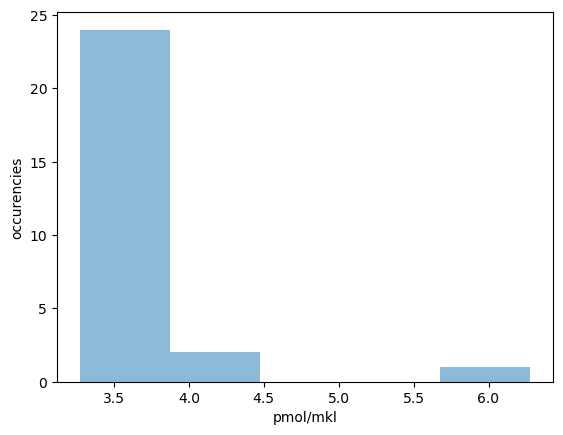

In [25]:
"""
смотрим распределение по корзинам
"""
ax = result['final conc, pmol/mkl'].plot.hist(bins=5, alpha=0.5)
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

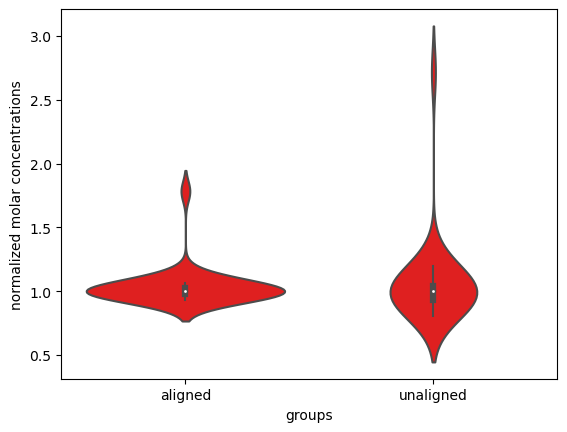

In [26]:
comparison_df = pd.DataFrame([initial_oligos_concentrations, result['final conc, pmol/mkl']]).T
comparison_df["unaligned"] = comparison_df["corrected_molar_concentration_pmol/mkl"]/comparison_df["corrected_molar_concentration_pmol/mkl"].median()
comparison_df["aligned"] = comparison_df['final conc, pmol/mkl']/comparison_df['final conc, pmol/mkl'].median()
comparison_df = comparison_df[["aligned", "unaligned"]]
comparison_df = comparison_df.melt(var_name='groups', value_name='normalized molar concentrations')

import seaborn as sns

ax = sns.violinplot(x = "groups", y="normalized molar concentrations", data=comparison_df, color='r', alpha = 0.1)


# final concentration dependency on yield:
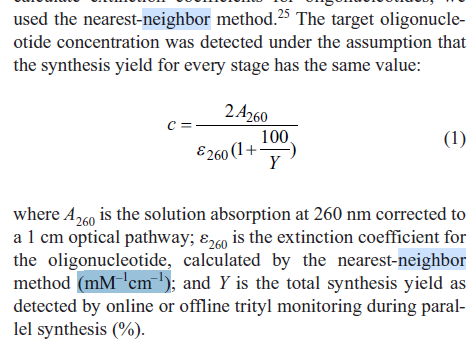
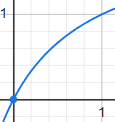

In [ ]:
Сравниваем 4 эксперимента 
 - с выравниванием и без + эти два с очисткой на магнитных частицах
 - Как сравнивать? 
     - смотреть распределение продуктов на капиллярном форезе
     - по интенсивности на форезе при одинаковом количестве циклов 
     - на риалтаймнике
 - Можно ли одновременно на риалтаймнике?
